# 06__tf_tissue_sp
# calculating tissue specificity of TFs (across HepG2, HeLa, and K562)

in this notebook, i calculate the tissue specificity of TFs across the 3 cell types in our MPRAs using ENCODE RNA-seq data. then, i correlate motif coverage (# bp covered and maximum coverage) as well as average TF specificity with MPRA activities and specificities.

note: the FIMO mappings and coverage calculations were done separately (see methods)

------

figures in this notebook:
- **Fig 3C**: KDE plot of correlations of MPRA activity & specificity with each of the 3 metrics

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from scipy import signal
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
index_dir = "../../data/00__index"
index_f = "%s/tss_oligo_pool.index.txt" % index_dir

In [4]:
hepg2_activ_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_element.txt"
hela_activ_f = "../../data/02__activs/POOL1__pMPRA1__HeLa__activities_per_element.txt"
k562_activ_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_element.txt"

In [5]:
fimo_f = "../../misc/05__fimo/pool1_fimo_map.txt"
fimo_chip_f = "../../misc/05__fimo/pool1_fimo_map.chip_intersected.txt"

In [6]:
fimo_cov_f = "../../data/04__coverage/FIMO.coverage.new.txt"
fimo_chip_cov_f = "../../data/04__coverage/FIMO.ChIPIntersect.coverage.new.txt"

In [7]:
tf_ts_f = "../../data/04__coverage/TF_tissue_specificities.from_CAGE.txt"

In [8]:
cage_v_mpra_f = "../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt"

## 1. import data

In [9]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo.columns = ["motif", "unique_id", "start", "end", "strand", "score", "pval", "qval", "seq"]
fimo.head()

,motif,unique_id,start,end,strand,score,pval,qval,seq
0,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA
1,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA
2,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA
3,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA
4,ZNF263,FLIPPED__Enhancer.flip.antisense__chr19:185263...,32,52,+,28.7347,2.680000e-12,2.160000e-07,GGAGGAGGAAGAGGAGGAGGG


In [10]:
fimo_chip = pd.read_table(fimo_chip_f, sep="\t")
fimo_chip.head()

,motif_chr,motif_start,motif_end,motif,motif_score,motif_strand,tss_chr,tss_start,tss_end,tss_info,tss_score,tss_strand,TSS_id,oligo_reg_x,oligo_reg_y,enhancer_id,oligo_reg,unique_id
0,chr1,714091,714092,Atf1,11.24590,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",0,-,"chr1:713985..714054,-","chr1:713977..714091,-",NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...
1,chr1,713979,713991,E2F1,11.96720,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",0,-,"chr1:713985..714054,-","chr1:713977..714091,-",NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...
2,chr1,714063,714076,JUN,10.02040,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",0,-,"chr1:713985..714054,-","chr1:713977..714091,-",NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...
3,chr1,713977,713988,YY1,9.98077,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",0,-,"chr1:713985..714054,-","chr1:713977..714091,-",NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...
4,chr1,53704213,53704221,Atf1,11.24590,+,chr1,53704155,53704270,"div_pc__p1@MAGOH__chr1:53704157..53704219,-",0,-,"chr1:53704157..53704219,-","chr1:53704155..53704269,-",NaN,NaN,"chr1:53704155..53704269,-",WILDTYPE__mrna.flip.sense__chr1:53704155..5370...


In [11]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "oligo_type", "unique_id", "dupe_info", "SNP", "seq_name"]]
index_elem = index_elem.drop_duplicates()

In [12]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")

In [13]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [14]:
fimo_cov = pd.read_table(fimo_cov_f, sep="\t")
fimo_cov = fimo_cov[["unique_id", "n_total_motifs", "n_unique_motifs", "max_cov", "n_bp_cov",
                     "log_n_total_motifs", "log_n_unique_motifs", "log_max_cov", "log_n_bp_cov"]]
fimo_cov.head()

,unique_id,n_total_motifs,n_unique_motifs,max_cov,n_bp_cov,log_n_total_motifs,log_n_unique_motifs,log_max_cov,log_n_bp_cov
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,48,35,19,83,3.871201,3.555348,2.944439,4.418841
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,37,29,16,84,3.610918,3.367296,2.772589,4.430817
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,10,8,3,77,2.302585,2.079442,1.098612,4.343805
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,12,8,5,54,2.484907,2.079442,1.609438,3.988984
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,37,31,22,80,3.610918,3.433987,3.091042,4.382027


In [15]:
fimo_chip_cov = pd.read_table(fimo_chip_cov_f, sep="\t")
fimo_chip_cov = fimo_chip_cov[["unique_id", "n_total_motifs", "n_unique_motifs", "max_cov", "n_bp_cov",
                               "log_n_total_motifs", "log_n_unique_motifs", "log_max_cov", "log_n_bp_cov"]]
fimo_chip_cov.head()

,unique_id,n_total_motifs,n_unique_motifs,max_cov,n_bp_cov,log_n_total_motifs,log_n_unique_motifs,log_max_cov,log_n_bp_cov
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,5,5,2,34,1.609438,1.609438,0.693147,3.526361
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,5,5,3,57,1.609438,1.609438,1.098612,4.043051
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,2,2,1,27,0.693147,0.693147,0.000000,3.295837
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,7,6,2,65,1.945910,1.791759,0.693147,4.174387
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,7,7,5,27,1.945910,1.945910,1.609438,3.295837


In [16]:
tf_ts = pd.read_table(tf_ts_f, sep="\t")
tf_ts.head()

,tf,tissue_sp_all,tissue_sp_3,K562_exp,HeLa_exp,HepG2_exp
0,PAX7,0.990032,NaN,0.000000,0.000000,0.000000
1,HNF1B,0.979589,0.666667,0.000000,0.000000,5.889702
2,LIN54,0.794230,0.412303,17.857032,18.290625,47.369957
3,IRF3,0.719361,0.089475,23.938784,29.128210,26.498907
4,MEF2C,0.978378,0.665278,112.089652,0.335948,0.131145


In [17]:
cage_v_mpra = pd.read_table(cage_v_mpra_f, sep="\t")
cage_v_mpra.head()

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,1.810702,0.665068,1.400056,0.142230
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,0.869834,0.151243,-0.054568,0.214384
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,2.898407,0.158191,1.378850,0.118103
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,2.161890,0.140302,0.130581,0.269957
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,1.070710,0.292028,3.046316,0.085757


## 2. find avg specificity per tile

In [18]:
fimo["motif"] = fimo["motif"].str.upper()
fimo = fimo.merge(tf_ts, left_on="motif", right_on="tf", how="left")
fimo.head()

,motif,unique_id,start,end,strand,score,pval,qval,seq,tf,tissue_sp_all,tissue_sp_3,K562_exp,HeLa_exp,HepG2_exp
0,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA,ZNF263,0.791717,0.196541,9.773098,15.522255,12.119118
1,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA,ZNF263,0.791717,0.196541,9.773098,15.522255,12.119118
2,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA,ZNF263,0.791717,0.196541,9.773098,15.522255,12.119118
3,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA,ZNF263,0.791717,0.196541,9.773098,15.522255,12.119118
4,ZNF263,FLIPPED__Enhancer.flip.antisense__chr19:185263...,32,52,+,28.7347,2.680000e-12,2.160000e-07,GGAGGAGGAAGAGGAGGAGGG,ZNF263,0.791717,0.196541,9.773098,15.522255,12.119118


In [19]:
fimo_chip["motif"] = fimo_chip["motif"].str.upper()
fimo_chip = fimo_chip.merge(tf_ts, left_on="motif", right_on="tf", how="left")
fimo_chip.head()

,motif_chr,motif_start,motif_end,motif,motif_score,motif_strand,tss_chr,tss_start,tss_end,tss_info,...,oligo_reg_y,enhancer_id,oligo_reg,unique_id,tf,tissue_sp_all,tissue_sp_3,K562_exp,HeLa_exp,HepG2_exp
0,chr1,714091,714092,ATF1,11.24590,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",...,NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,ATF1,0.722831,0.304699,46.204331,66.441018,25.944232
1,chr1,713979,713991,E2F1,11.96720,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",...,NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,E2F1,0.886909,0.325681,8.734665,48.370651,40.746397
2,chr1,714063,714076,JUN,10.02040,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",...,NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,JUN,0.945275,0.442650,6.565028,6.670227,19.693893
3,chr1,713977,713988,YY1,9.98077,+,chr1,713977,714092,"intergenic__p1@ENST00000428504,p1@uc001abo.2__...",...,NaN,NaN,"chr1:713977..714091,-",WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,YY1,0.659442,0.144840,55.047128,73.832986,60.536861
4,chr1,53704213,53704221,ATF1,11.24590,+,chr1,53704155,53704270,"div_pc__p1@MAGOH__chr1:53704157..53704219,-",...,NaN,NaN,"chr1:53704155..53704269,-",WILDTYPE__mrna.flip.sense__chr1:53704155..5370...,ATF1,0.722831,0.304699,46.204331,66.441018,25.944232


In [20]:
len(fimo)

121996

In [21]:
len(fimo_chip)

3346

In [22]:
fimo_nonan = fimo[~pd.isnull(fimo["tissue_sp_3"])]
len(fimo_nonan)

95675

In [23]:
fimo_chip_nonan = fimo_chip[~pd.isnull(fimo_chip["tissue_sp_3"])]
len(fimo_chip_nonan)

3290

In [24]:
fimo_deduped = fimo_nonan.drop_duplicates(subset=["motif", "unique_id"])
len(fimo_deduped)

68981

In [25]:
fimo_chip_deduped = fimo_chip_nonan.drop_duplicates(subset=["motif", "unique_id"])
len(fimo_chip_deduped)

3249

In [26]:
avg_sp_fimo = fimo_deduped.groupby(["unique_id"])["tissue_sp_3"].agg("mean").reset_index()
avg_sp_fimo.columns = ["unique_id", "avg_tf_tissue_sp"]
avg_sp_fimo.head()

,unique_id,avg_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,0.304391
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,0.409446
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.384379
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.388853
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.411511


In [27]:
avg_sp_fimo_chip = fimo_chip_deduped.groupby(["unique_id"])["tissue_sp_3"].agg("mean").reset_index()
avg_sp_fimo_chip.columns = ["unique_id", "avg_tf_tissue_sp"]
avg_sp_fimo_chip.head()

,unique_id,avg_tf_tissue_sp
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.264009
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.343763
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.162771
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.327722
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.367769


In [28]:
med_sp_fimo = fimo_deduped.groupby(["unique_id"])["tissue_sp_3"].agg("median").reset_index()
med_sp_fimo.columns = ["unique_id", "med_tf_tissue_sp"]
med_sp_fimo.head()

,unique_id,med_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,0.213972
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,0.402299
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.317076
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.331621
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.324284


In [29]:
med_sp_fimo_chip = fimo_chip_deduped.groupby(["unique_id"])["tissue_sp_3"].agg("median").reset_index()
med_sp_fimo_chip.columns = ["unique_id", "med_tf_tissue_sp"]
med_sp_fimo_chip.head()

,unique_id,med_tf_tissue_sp
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.266032
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.290029
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.162771
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.311208
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.472201


In [30]:
tissue_sp_fimo = avg_sp_fimo.merge(med_sp_fimo, on="unique_id")
tissue_sp_fimo["log_avg_tf_tissue_sp"] = np.log(tissue_sp_fimo["avg_tf_tissue_sp"]+1)
tissue_sp_fimo["log_med_tf_tissue_sp"] = np.log(tissue_sp_fimo["med_tf_tissue_sp"]+1)
tissue_sp_fimo.head()

,unique_id,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,0.304391,0.213972,0.265737,0.193898
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,0.409446,0.402299,0.343196,0.338113
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.384379,0.317076,0.325252,0.275414
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.388853,0.331621,0.328478,0.286397
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.411511,0.324284,0.344661,0.280872


In [31]:
tissue_sp_fimo_chip = avg_sp_fimo_chip.merge(med_sp_fimo_chip, on="unique_id")
tissue_sp_fimo_chip["log_avg_tf_tissue_sp"] = np.log(tissue_sp_fimo_chip["avg_tf_tissue_sp"]+1)
tissue_sp_fimo_chip["log_med_tf_tissue_sp"] = np.log(tissue_sp_fimo_chip["med_tf_tissue_sp"]+1)
tissue_sp_fimo_chip.head()

,unique_id,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.264009,0.266032,0.234288,0.235888
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.343763,0.290029,0.295474,0.254665
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.162771,0.162771,0.150806,0.150806
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.327722,0.311208,0.283465,0.270949
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,0.367769,0.472201,0.313181,0.386758


## 3. find tissue specificity per tile

In [32]:
mean_activ_fimo = cage_v_mpra.merge(tissue_sp_fimo, on="unique_id")
mean_activ_fimo.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
240,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,Enhancer,0.018383,0.396783,-1.939413,0.421748,0.455059,0.497550,0.375046,0.403830
848,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr4:387...,protein_coding,0.010581,0.666667,-0.728335,0.148198,0.276130,0.342912,0.243832,0.294841
2044,WILDTYPE__mrna.noflip.NA__chr7:93204001..93204...,protein_coding,0.000000,NaN,-1.087826,0.095572,0.394077,0.346578,0.332232,0.297567
106,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,intergenic,0.308449,0.406588,2.103994,0.053100,0.337096,0.350244,0.290500,0.300285
1305,WILDTYPE__Enhancer.noflip.NA__chr16:86965152.....,Enhancer,0.032195,0.666667,-2.224334,0.156665,0.446001,0.439685,0.368802,0.364424


In [33]:
fimo_cov.head()

,unique_id,n_total_motifs,n_unique_motifs,max_cov,n_bp_cov,log_n_total_motifs,log_n_unique_motifs,log_max_cov,log_n_bp_cov
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,48,35,19,83,3.871201,3.555348,2.944439,4.418841
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,37,29,16,84,3.610918,3.367296,2.772589,4.430817
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,10,8,3,77,2.302585,2.079442,1.098612,4.343805
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,12,8,5,54,2.484907,2.079442,1.609438,3.988984
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,37,31,22,80,3.610918,3.433987,3.091042,4.382027


In [34]:
mean_activ_fimo = mean_activ_fimo.merge(fimo_cov, on="unique_id")
mean_activ_fimo.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp,n_total_motifs,n_unique_motifs,max_cov,n_bp_cov,log_n_total_motifs,log_n_unique_motifs,log_max_cov,log_n_bp_cov
1982,WILDTYPE__mrna.noflip.NA__chr21:42798059..4279...,protein_coding,0.018144,0.666667,-0.259744,0.034225,0.400010,0.324284,0.336480,0.280872,22,20,17,95,3.091042,2.995732,2.833213,4.553877
1826,WILDTYPE__mrna.flip.sense__chr2:27579833..2757...,div_pc,1.859131,0.099385,-1.613957,0.175771,0.387645,0.439664,0.327608,0.364410,7,7,3,44,1.945910,1.945910,1.098612,3.784190
24,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,1.295849,0.666667,1.744206,0.151705,0.364583,0.305103,0.310849,0.266282,38,31,24,67,3.637586,3.433987,3.178054,4.204693
1451,WILDTYPE__Enhancer.noflip.NA__chr7:44677823..4...,Enhancer,0.316283,0.666667,-1.597019,0.258111,0.488785,0.520827,0.397961,0.419254,31,28,23,64,3.433987,3.332205,3.135494,4.158883
89,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,div_lnc,0.015860,0.666667,-1.476764,0.294307,0.286443,0.324284,0.251881,0.280872,6,5,4,51,1.791759,1.609438,1.386294,3.931826


In [35]:
mean_activ_fimo_chip = cage_v_mpra.merge(tissue_sp_fimo_chip, on="unique_id")
mean_activ_fimo_chip.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
357,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr6:347...,protein_coding,3.069156,0.071924,-0.295720,0.145786,0.393291,0.325681,0.331668,0.281926
205,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr21...,intergenic,0.000000,NaN,0.273860,0.233957,0.473003,0.473003,0.387303,0.387303
243,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr11:6...,protein_coding,3.787208,0.048258,2.617666,0.171002,0.230764,0.225678,0.207635,0.203494
503,WILDTYPE__Enhancer.flip.sense__chr1:26827439.....,Enhancer,0.949664,0.297224,-1.800926,NaN,0.393817,0.381450,0.332046,0.323134
277,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr6:96...,div_pc,3.553027,0.079464,1.424475,0.168422,0.309556,0.309556,0.269688,0.269688


In [36]:
mean_activ_fimo_chip = mean_activ_fimo_chip.merge(fimo_chip_cov, on="unique_id")
mean_activ_fimo_chip.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp,n_total_motifs,n_unique_motifs,max_cov,n_bp_cov,log_n_total_motifs,log_n_unique_motifs,log_max_cov,log_n_bp_cov
524,WILDTYPE__Enhancer.noflip.NA__chr10:74032412.....,Enhancer,0.756452,0.509430,-1.960498,0.449185,0.525147,0.564277,0.422091,0.447424,5,5,4,27,1.609438,1.609438,1.386294,3.295837
32,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,intergenic,1.473302,0.428820,-0.635878,0.127076,0.666667,0.666667,0.510826,0.510826,1,1,1,14,0.000000,0.000000,0.000000,2.639057
488,WILDTYPE__Enhancer.flip.sense__chr14:105948394...,Enhancer,0.270124,0.586244,-1.865186,0.113662,0.522747,0.522747,0.420516,0.420516,1,1,1,12,0.000000,0.000000,0.000000,2.484907
536,WILDTYPE__Enhancer.noflip.NA__chr11:65255188.....,Enhancer,0.214251,0.527092,-2.061971,0.122433,0.307187,0.265413,0.267877,0.235399,8,8,5,58,2.079442,2.079442,1.609438,4.060443
129,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr2...,Enhancer,0.736238,0.114857,1.135325,0.171504,0.389033,0.381729,0.328608,0.323335,5,5,3,40,1.609438,1.609438,1.098612,3.688879


## 4. plot correlations w/ MPRA data

## tissue specificity

#### fimo only

In [37]:
#cmap = sns.light_palette("#8da0cb", as_cmap=True)
cmap = sns.light_palette("darkslategray", as_cmap=True)

In [38]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_avg_tf_tissue_sp"]) &
                         ~pd.isnull(mean_activ_fimo["mpra_activ"])]

r: -0.189914085238, spearman p: 4.63857152383e-18


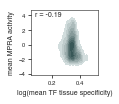

In [39]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_3.pdf", bbox_inches="tight", dpi="figure")

In [40]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_avg_tf_tissue_sp"]) &
                         ~pd.isnull(mean_activ_fimo["mpra_ts"])]

r: 0.178457917206, spearman p: 1.90474180664e-15


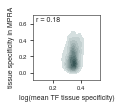

In [41]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [42]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_avg_tf_tissue_sp"]) &
                              ~pd.isnull(mean_activ_fimo_chip["mpra_activ"])]

r: -0.188992759675, spearman p: 5.65147994308e-08


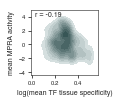

In [43]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_3.pdf", bbox_inches="tight", dpi="figure")

In [44]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_avg_tf_tissue_sp"]) &
                              ~pd.isnull(mean_activ_fimo_chip["mpra_ts"])]

r: 0.174484990707, spearman p: 9.74923010822e-07


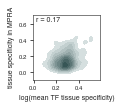

In [45]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

## number of bp covered

#### fimo only

In [46]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_n_bp_cov"]) &
                         ~pd.isnull(mean_activ_fimo["mpra_activ"])]

r: 0.285024146464, spearman p: 1.5886278675e-39


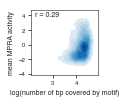

In [47]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_1.pdf", bbox_inches="tight", dpi="figure")

In [48]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_n_bp_cov"]) &
                         ~pd.isnull(mean_activ_fimo["mpra_ts"])]

r: -0.170268799265, spearman p: 3.53227511359e-14


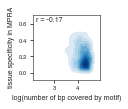

In [49]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [50]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_n_bp_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["mpra_activ"])]

r: 0.441460649203, spearman p: 4.21756794424e-40


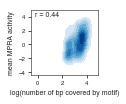

In [51]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_1.pdf", bbox_inches="tight", dpi="figure")

In [52]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_n_bp_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["mpra_ts"])]

r: -0.313538101667, spearman p: 3.30017216655e-19


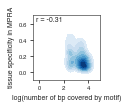

In [53]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

## mean overlapping coverage

#### fimo only

In [54]:
cmap = sns.light_palette("firebrick", as_cmap=True)

In [55]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_max_cov"]) &
                         ~pd.isnull(mean_activ_fimo["mpra_activ"])]

r: 0.369728534301, spearman p: 2.93206659497e-67


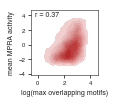

In [56]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_2.pdf", bbox_inches="tight", dpi="figure")

In [57]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_max_cov"]) &
                         ~pd.isnull(mean_activ_fimo["mpra_ts"])]

r: -0.275862481994, spearman p: 1.83320940414e-35


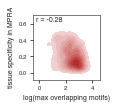

In [58]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [59]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_max_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["mpra_activ"])]

r: 0.29930477588, spearman p: 2.74038017328e-18


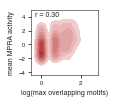

In [60]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_2.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_max_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["mpra_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

## 5. plot correlations w/ CAGE data

## TF tissue specificity

#### fimo only

In [ ]:
#cmap = sns.light_palette("#8da0cb", as_cmap=True)
cmap = sns.light_palette("darkslategray", as_cmap=True)

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_avg_tf_tissue_sp"]) &
                         ~pd.isnull(mean_activ_fimo["cage_activ"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("CAGE expression")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_avg_tf_tissue_sp"]) &
                         ~pd.isnull(mean_activ_fimo["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_avg_tf_tissue_sp"]) &
                              ~pd.isnull(mean_activ_fimo_chip["cage_activ"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("CAGE expression")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_avg_tf_tissue_sp"]) &
                              ~pd.isnull(mean_activ_fimo_chip["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

## # bp covered

#### fimo only

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_n_bp_cov"]) &
                         ~pd.isnull(mean_activ_fimo["cage_activ"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["cage_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("CAGE expression")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["cage_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_n_bp_cov"]) &
                         ~pd.isnull(mean_activ_fimo["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["cage_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_n_bp_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["cage_activ"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["cage_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("CAGE expression")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["cage_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_n_bp_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_n_bp_cov"], no_nan["cage_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_n_bp_cov"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

## mean overlapping motifs

#### fimo only

In [ ]:
cmap = sns.light_palette("firebrick", as_cmap=True)

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_max_cov"]) &
                         ~pd.isnull(mean_activ_fimo["cage_activ"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["cage_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("CAGE expression")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["cage_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["log_max_cov"]) &
                         ~pd.isnull(mean_activ_fimo["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["cage_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_max_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["cage_activ"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["cage_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("CAGE expression")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["cage_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
no_nan = mean_activ_fimo_chip[~pd.isnull(mean_activ_fimo_chip["log_max_cov"]) &
                              ~pd.isnull(mean_activ_fimo_chip["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["cage_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

### check correlation b/w CAGE and MPRA ts

In [ ]:
no_nan = mean_activ_fimo[~pd.isnull(mean_activ_fimo["mpra_ts"]) &
                         ~pd.isnull(mean_activ_fimo["cage_ts"])]

In [ ]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["mpra_ts"], no_nan["cage_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in CAGE")
ax.set_xlabel("tissue specificity in MPRA")

r, p = stats.spearmanr(no_nan["mpra_ts"], no_nan["cage_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

## 6. write files

In [ ]:
mean_activ_fimo.drop(["med_tf_tissue_sp", "log_med_tf_tissue_sp"], axis=1, inplace=True)

In [ ]:
mean_activ_fimo_chip.drop(["med_tf_tissue_sp", "log_med_tf_tissue_sp"], axis=1, inplace=True)

In [ ]:
out_dir = "../../data/04__coverage"
!mkdir -p $out_dir
mean_activ_fimo.to_csv("%s/FIMO.coverage.new.txt" % out_dir, sep="\t", index=False)
mean_activ_fimo_chip.to_csv("%s/FIMO.ChIPIntersect.coverage.new.txt" % out_dir, sep="\t", index=False)